<img src = "https://github.com/VeryFatBoy/notebooks/blob/main/common/images/img_github_singlestore-jupyter_featured_2.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Using SingleStore and WebAssembly for Sentiment Analysis of Stack Overflow Comments</h1>
    </div>
</div>

In [7]:
!pip install statsmodels --quiet

In [8]:
import pandas as pd
import plotly.express as px

In [11]:
%%sql
DROP DATABASE IF EXISTS demo;

CREATE DATABASE IF NOT EXISTS demo;

1 rows affected.

++
||
++
++

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook.</p>
    </div>
</div>

In [13]:
%%sql
CREATE LINK IF NOT EXISTS gcs_wasm AS GCS CREDENTIALS '{}'
    DESCRIPTION 'wasm and wit examples';

1 rows affected.

++
||
++
++

In [14]:
%%sql
DROP TABLE IF EXISTS comments;

CREATE TABLE IF NOT EXISTS comments (
    id INT,
    text TEXT,
    creation_date TIMESTAMP,
    score INT,
    score_bucket AS (score - (score % 10)) PERSISTED INT,
    KEY (score) USING CLUSTERED COLUMNSTORE,
    SHARD KEY ()
);

++
||
++
++

In [16]:
%%sql
CREATE PIPELINE sowasm AS LOAD DATA LINK gcs_wasm 'stackoverflow-wasm'
INTO TABLE comments
FIELDS TERMINATED BY ','
ENCLOSED BY '\"'
ESCAPED BY '\\'
LINES TERMINATED BY '\n'
STARTING BY '';

++
||
++
++

In [17]:
%%sql
TEST PIPELINE sowasm LIMIT 1;

1 rows affected.

id,text,creation_date,score
118510849,Also where did that OR come from? bcz i have not used it anywhere.,2021-04-11 15:31:52,0


In [18]:
%%sql
START PIPELINE sowasm;

++
||
++
++

In [19]:
%%sql
SELECT pipeline_name, batch_state, batch_time, rows_per_sec, mb_per_sec 
FROM information_schema.pipelines_batches_summary;

2 rows affected.

pipeline_name,batch_state,batch_time,rows_per_sec,mb_per_sec
sowasm,In Progress,5.541557,409776.5303144946,81.27906434960427
sowasm,Succeeded,14.659567,0.5457187105185304,501.912665974377


In [41]:
%%sql
SELECT pipeline_name, file_state, COUNT(*) 
FROM information_schema.pipelines_files 
GROUP BY 1, 2;

1 rows affected.

pipeline_name,file_state,COUNT(*)
sowasm,Loaded,16


In [42]:
%%sql
SELECT COUNT(*) FROM comments;

1 rows affected.

COUNT(*)
82037742


In [43]:
%%sql
OPTIMIZE TABLE comments FULL;

Table,Op,Msg_type,Msg_text


In [48]:
%%sql
DROP FUNCTION IF EXISTS sentiment;

CREATE FUNCTION sentiment RETURNS TABLE AS WASM
FROM LINK gcs_wasm 'wasm-modules/sentimentable.wasm'
WITH WIT FROM LINK gcs_wasm 'wasm-modules/sentimentable.wit';

1 rows affected.

++
||
++
++

In [49]:
%%sql
SELECT * FROM sentiment('The movie was great')

1 rows affected.

compound,positive,negative,neutral
0.6248933269389457,0.5774647887323944,0.0,0.4225352112676057


In [50]:
%%sql
SELECT * FROM sentiment('The movie was GREAT!')

1 rows affected.

compound,positive,negative,neutral
0.7290259049799065,0.6307692307692307,0.0,0.36923076923076925


In [51]:
%%sql
SELECT
    score_bucket,
    COUNT(*) AS num_comments,
    ABS(MIN(sentiment.compound)) AS 'negative',
    MAX(sentiment.compound) AS 'positive'
FROM (
        SELECT score_bucket, text
        FROM comments
        WHERE score >= 10
    ) AS c
JOIN sentiment(c.text) AS sentiment
GROUP BY 1
HAVING positive > 0 AND negative > 0 AND num_comments > 20
ORDER BY 1 ASC;

33 rows affected.

score_bucket,num_comments,negative,positive
10,115285,0.9994079336366717,0.9884804181816502
20,27409,0.9888823100791507,0.9892404342635115
30,12064,0.9821512068585552,0.9877005097673762
40,6701,0.9843907526148696,0.9879442138133854
50,4130,0.9578388745735287,0.9771454595448407
60,2737,0.9760934140752651,0.9729132860697197
70,1871,0.9706903352612597,0.9880242850306352
80,1382,0.9652000828396454,0.9762188560813158
90,961,0.923147976982903,0.9493088246302036
100,616,0.9304284852393788,0.9450887908327322


<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [52]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

In [53]:
df = pd.read_sql(
    "SELECT * FROM comments LIMIT 10;",
    con = db_connection
)

df.head()

,id,text,creation_date,score,score_bucket
0,86534189,@ashutosh_pandey Just one question. Can I use ...,2018-04-10 17:23:38,0,0
1,87104892,I think the manual says what you are saying in...,2018-04-26 13:33:13,0,0
2,87101658,I'm not sure what you are asking/saying.,2018-04-26 12:22:45,0,0
3,87097653,"Yep, it does too for me now ;-) Nevertheless, ...",2018-04-26 10:39:45,0,0
4,105479143,Thank you. I can only get a new dataframe when...,2020-01-09 08:14:48,0,0


In [54]:
df = pd.read_sql("""
SELECT
    score_bucket,
    COUNT(*) AS num_comments,
    ABS(MIN(sentiment.compound)) AS 'negative',
    MAX(sentiment.compound) AS 'positive'
FROM (
        SELECT score_bucket, text
        FROM comments
        WHERE score >= 10
    ) AS c
JOIN sentiment(c.text) AS sentiment
GROUP BY 1
HAVING positive > 0 AND negative > 0 AND num_comments > 20
ORDER BY 1 ASC;
""", con = db_connection)

df.head()

,score_bucket,num_comments,negative,positive
0,10,115285,0.999408,0.988480
1,20,27409,0.988882,0.989240
2,30,12064,0.982151,0.987701
3,40,6701,0.984391,0.987944
4,50,4130,0.957839,0.977145


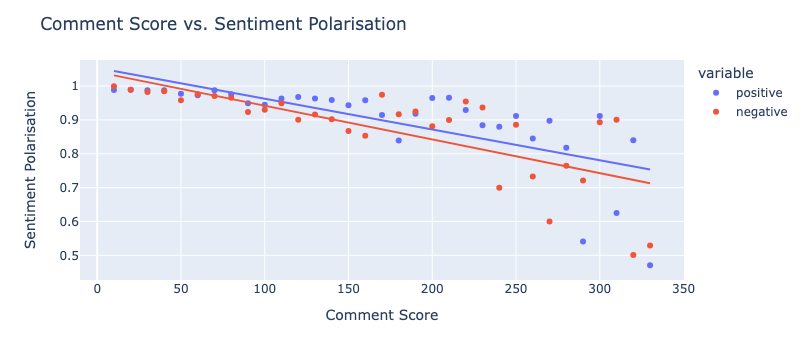

In [57]:
fig = px.scatter(
    df,
    x = "score_bucket",
    y = ["positive", "negative"],
    trendline = "ols",
    labels = {
        "score_bucket": "Comment Score",
        "value": "polarization",
    }
)

fig.update_layout(
    title = "Comment Score vs. Sentiment Polarisation",
    xaxis_title = "Comment Score",
    yaxis_title = "Sentiment Polarisation"
)

fig.show()

## Cleanup

In [58]:
%%sql
STOP PIPELINE sowasm;

++
||
++
++

In [59]:
%%sql
DROP PIPELINE sowasm;

++
||
++
++

In [60]:
%%sql
DROP LINK gcs_wasm;

1 rows affected.

++
||
++
++

In [61]:
%%sql
DROP TABLE comments;

++
||
++
++

In [62]:
%%sql
DROP DATABASE demo;

++
||
++
++